**классификатор текстов LSTM**

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
tqdm.pandas()

In [4]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [5]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [6]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [7]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [8]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [9]:
data.sample(10)

,id,ttext,ttype
81401,410756204844294145,RT @LazavikNata: Самый классный ;) http://t.co/5tpmXE9BIR,1
45096,414403499339030528,"Я ненавижу сегодняшний день...все планы обломала тупая ген.репетиция...А я еще,я лох-уронила стакан с бабл чаем и он весь растекся по полу((",-1
73911,418385034408890368,RT @balabanmiu: @Viculyamur я че т скучаю уже :(,-1
20223,411570847187337216,libre.fm не хочет принимать скробблы :( 68 штук,-1
14718,409340684186181632,у всех левшей такой странный почерк или что? :-) http://t.co/F8aR3o7fcS,1
82845,419862831283326977,@castiel_dant не знаю((( \nЭто наверное из-за печенек:С,-1
17507,409371725701578752,Каждая эмоция в фильме написана на лице актера! Очень хорошая игра)),1
65183,410366197910491136,@RusikNodia покатайтесь на суши возе зимой:)))) пизда экшэн:),1
109629,411175147476111360,RT @Rina25rus25: Самая замечательная серия!до слёз:),1
73980,410628439881043969,"@ChristyZobnina не парься)) сегодня день такой, можно опоздать",1


## очистка данных

In [10]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 118338.51it/s]


In [11]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [12]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 102656.09it/s]


In [13]:
data.sample(3)

,id,ttext,ttype,ttext_clean
31734,412967326808829952,"Не в этом суть там,в впереди был мальчик я когда упала он подал мне руку...а я как дура гоордая встала и пошла,он милый был между прочим;(",-1,"[не, в, этом, суть, там, в, впереди, был, мальчик, я, когда, упала, он, подал, мне, руку, а, я, как, дура, гоордая, встала, и, пошла, он, милый, был, между, прочим]"
71233,410474882854420480,Радости выше крыши) теперь буду ждать 14 с нетерпением))),1,"[радости, выше, крыши, теперь, буду, ждать, digit, с, нетерпением, happysmile]"
92539,410862630057046017,"RT @jihohuqehiw: Нада в яндекс маркете отзыв написать, хороший=)",1,"[rt, jihohuqehiw, нада, в, яндекс, маркете, отзыв, написать, хороший]"


In [14]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 438483.69it/s]


In [15]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [16]:
data.sample(3)

,id,ttext,ttype,ttext_clean
124996,410392970924285952,мое супераккуратное обращение с суперклеем войдет в легенды((,-1,"[мое, супераккуратное, обращение, суперклеем, войдет, легенды, sadsmile]"
6488,409086189082513408,Ееееей 47 КАПЕЕЕЕЦ ПРОООСТО:DDDD http://t.co/GNYvIC1Hyi,1,"[ееееей, digit, капеееец, прооосто, happysmile, ddd, url]"
105003,411126153751973889,"@TheRealMdel везет) ну эт ничего, мне уже в понедельник в окопы. а я ещё нихрена не знаю. как буду учиться не понятно..",1,"[therealmdel, везет, ничего, мне, уже, понедельник, окопы, ещё, нихрена, знаю, как, буду, учиться, понятно]"


## словарь

In [17]:
voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
voc = { w:i+1 for i,w in enumerate(voc) }
voc['<pad>']= 0
ppr(voc)

записей: 239 518


In [18]:
voc

{'aaa': 1,
 'aaaa': 2,
 'aaaaa': 3,
 'aaaaaaaaaa': 4,
 'aaaaaaaaaaart': 5,
 'aaaaaahhhhhhwow': 6,
 'aaaasyaaa': 7,
 'aaaats': 8,
 'aaahaahaaaah': 9,
 'aaaidar': 10,
 'aaaiguuul': 11,
 'aaakristya': 12,
 'aaalsusha': 13,
 'aaarrrrrrrr': 14,
 'aaaw': 15,
 'aaburnashov': 16,
 'aafrolova': 17,
 'aakarimova': 18,
 'aakellah': 19,
 'aakuzichev': 20,
 'aaleksandra': 21,
 'aaleksandrowna': 22,
 'aalello': 23,
 'aalexithymiaa': 24,
 'aalistok': 25,
 'aalive': 26,
 'aallanavaz': 27,
 'aalove': 28,
 'aammmmmmmm': 29,
 'aamnastya': 30,
 'aamooorr': 31,
 'aamy': 32,
 'aanaokay': 33,
 'aanastasiaden': 34,
 'aandrushkas': 35,
 'aanechaev': 36,
 'aanjkaa': 37,
 'aanneeeet': 38,
 'aannybarry': 39,
 'aanvarova': 40,
 'aanxaa': 41,
 'aapogodina': 42,
 'aarn': 43,
 'aaronpaul': 44,
 'aasexuality': 45,
 'aashirokov': 46,
 'aasokol': 47,
 'aasviridova': 48,
 'aatemkin': 49,
 'aavsasha': 50,
 'aavst': 51,
 'aaw': 52,
 'aaww': 53,
 'aaxaxaax': 54,
 'aayra': 55,
 'aazbaeva': 56,
 'abachurin': 57,
 'abaevart': 

## строим датасет

In [19]:
# заменяем слова на номера в словаре
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 226831/226831 [00:00<00:00, 239770.52it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
220123,"@KatyaAkatova сегодня я ходила в колготках,джинсах,2х свитерах,шапке ,варежках ,куртке, шарфе,но все равно замерзла. У нас тут -20((","[katyaakatova, сегодня, ходила, колготках, джинсах, свитерах, шапке, варежках, куртке, шарфе, все, равно, замерзла, нас, тут, digit, sadsmile]","[27966, 197699, 227798, 125477, 100944, 196952, 233162, 83225, 130756, 233273, 89214, 187697, 112104, 146462, 217075, 13805, 51505]"
102878,Вчерашнее фото любимой Лизочки &gt;) http://t.co/6MBcxufGOt,"[вчерашнее, фото, любимой, лизочки, happysmile, url]","[90186, 225130, 134988, 133156, 21932, 61231]"
16481,Вера Полозкова!) спасибо за это @vague_thoughts http://t.co/UPOnTTIgI5,"[вера, полозкова, спасибо, это, vague, thoughts, url]","[84248, 174084, 205355, 237045, 61507, 58941, 61231]"


In [21]:
# оценка длины последовательностей
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

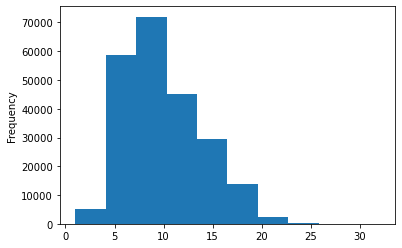

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длинна
code_max_len = data['code'].str.len().max()
code_max_len

32

In [24]:
# выравниваем длину последовательностей
z = [0]*code_max_len # дополняем нулями короткие последовательности
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 335468.78it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    226831
mean         32
std           0
min          32
25%          32
50%          32
75%          32
max          32
Name: code, dtype: int64

---

In [26]:
# собираем матрицу датасета
x = np.stack( data['code'].values).astype(int)

# для повышения эффективности работы рекуррентной модели
# переворачиваем последовательности, 
# код первого слова в конце, 
# нули дополнения в начале
x = np.flip(x,axis=1)

x.shape

(226831, 32)

In [27]:
# метка класса {0,1}
n_classes = 2 # количество классов
y = (data['ttype'].values+1) // 2
y.shape

(226831,)

In [28]:
max_word = x.max() # максимальный номер слова
seq_len = x.shape[1] # длина последовательности

max_word, seq_len

(239517, 32)

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32), (136098,), (90733, 32), (90733,))

In [30]:
# количество позитивных примеров в train и test наборах
y_train.sum(axis=0),y_test.sum(axis=0),

(69003, 45906)

----

In [31]:
# def get_batch(x,y,batch_size=512):
#     n = x.shape[0] # количество примеров
#     pt = int(np.ceil(n/batch_size)) # количество батчей
    
#     # случайным образом мешаем примеры и режем на батчи
#     ii = rng.permutation(n)
#     xr,yr = np.array_split(x[ii,:],pt), np.array_split(y[ii],pt)
    
#     for i in range(pt): # генератор выдаёт батчи
#         yield i,xr[i],yr[i]

In [32]:
# batches = get_batch(x_train,y_train,batch_size=512)    
# for i,xb,yb in batches: 
#     print(i,xb.shape)

---

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_ds = TensorDataset( torch.tensor(x_train), torch.tensor(y_train) )
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

In [34]:
# def preprocess(x, y):
#     return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

# class WrappedDataLoader:
#     def __init__(self, dl, func):
#         self.dl = dl
#         self.func = func

#     def __len__(self):
#         return len(self.dl)

#     def __iter__(self):
#         batches = iter(self.dl)
#         for b in batches:
#             yield (self.func(*b))


# train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

# train_dl = WrappedDataLoader(train_dl, preprocess)
# valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [35]:
# for xb, yb in train_dl: 
#     print(xb.shape,yb.shape)
#     break
#
## > torch.Size([1024, 32]) torch.Size([1024])

## строим модель

In [36]:
embedding_dim = 64 # размер выхода эмбединга
hidden_dim = 32 # размер рекуррентного слоя

In [37]:
class Model(nn.Module):
    def __init__(self, 
                 num_embeddings=max_word+1, # размер входа эмбединга (длина OHE)
                 emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        out = self.sftm(out)
        return out 

In [38]:
model = Model()
model

Model(
  (emb): Embedding(239518, 64)
  (rnn): LSTM(64, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

In [39]:
# z = torch.zeros( size=(1,seq_len), dtype=torch.int, requires_grad=False)
# out = model(z)
# make_dot( out, params=dict(list(model.named_parameters())), ) #show_attrs=True )  
# # .render("rnn_torchviz", format="png")

## обучаем модель

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [41]:
model = model.to(device)

In [42]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [43]:
%%time

epochs = 32
hist = []
for i in range(epochs):
#    batches = get_batch(x_train,y_train,batch_size=1024)    
#     for j,xb,yb in batches: 
#        xt,yt = torch.tensor(xb).to(device), torch.tensor(yb).to(device)

    for j,(xb,yb) in enumerate(train_dl):
        xt,yt = xb.to(device), yb.to(device)
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xt) # вычисляем выход, прямой проход
        loss = loss_function(out,yt) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
#         del xt
#         del yt
       

    #if((i%3)==1): print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')


epoch:   0 loss: 0.42056528
epoch:   1 loss: 0.41058794
epoch:   2 loss: 0.37801975
epoch:   3 loss: 0.35223332
epoch:   4 loss: 0.35043538
epoch:   5 loss: 0.35536140
epoch:   6 loss: 0.37192044
epoch:   7 loss: 0.36705253
epoch:   8 loss: 0.37291595
epoch:   9 loss: 0.36560619
epoch:  10 loss: 0.36933243
epoch:  11 loss: 0.36758626
epoch:  12 loss: 0.37322465
epoch:  13 loss: 0.35860109
epoch:  14 loss: 0.35118467
epoch:  15 loss: 0.37142253
epoch:  16 loss: 0.36484835
epoch:  17 loss: 0.36380166
epoch:  18 loss: 0.37422726
epoch:  19 loss: 0.39663321
epoch:  20 loss: 0.41633332
epoch:  21 loss: 0.40303516
epoch:  22 loss: 0.40208182
epoch:  23 loss: 0.37948674
epoch:  24 loss: 0.38073644
epoch:  25 loss: 0.39153990
epoch:  26 loss: 0.36051300
epoch:  27 loss: 0.37364128
epoch:  28 loss: 0.35774478
epoch:  29 loss: 0.37576851
epoch:  30 loss: 0.36061692
epoch:  31 loss: 0.36695966
CPU times: user 1min 24s, sys: 297 ms, total: 1min 24s
Wall time: 1min 23s


In [44]:
torch.cuda.empty_cache()

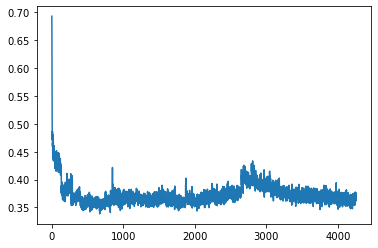

In [45]:
# изменение значения потери в процессе обучения
plt.plot(hist)

## тест

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [47]:
xt = torch.tensor(x_test).to(device)
out = model(xt)
scores = out.cpu().detach().numpy()
y_pred = np.argmax( scores ,axis=1)

In [48]:
del xt
torch.cuda.empty_cache()

In [49]:
accuracy_score(y_test, y_pred)

0.8534270882699789

In [50]:
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.85      0.86      0.85     44827
           1       0.86      0.85      0.85     45906

    accuracy                           0.85     90733
   macro avg       0.85      0.85      0.85     90733
weighted avg       0.85      0.85      0.85     90733



----

In [51]:
# from matplotlib import pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense

# embedding_size = 64

# model = Sequential()
# model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
# model.add(LSTM(32))
# model.add(Dense(n_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])


# hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

# model.evaluate( x_test ,y_test )

# k = hist.history.keys()
# w,h = 6,4
# fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
# for i,n in enumerate(k):
#     ax[i].plot(hist.history[n],label=n)
#     ax[i].grid(True)
#     ax[i].legend()
#     ax[i].set_ylim([-.1,1.1])